<a href="https://colab.research.google.com/github/RoyRin/multi-party-learning/blob/master/PATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%%capture
#! python3 -m pip install -r /content/drive/MyDrive/academics/columbia/neural_networks/project/requirements.txt
#!cat /content/drive/MyDrive/academics/columbia/neural_networks/project/requirements.txt | grep "syft"
!pip install torchviz
!pip install torch torchvision
!pip install tensorboard
!pip install --upgrade syft torch numpy


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=9039eed47b22f3b6849364969677b200e724e0979cae60cc6ba6275333a0a756
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
     |████████████████████████████████| 606 kB 4.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x55b328eec000 @  0x7fb623c4b615 0x55b2ef4c54cc 0x55b2ef5a547a 0x55b2ef4c82ed 0x55b2ef5b9e1d 0x55b2ef53be99 0x55b2ef5369ee 0x55b2ef4c9bda 0x55b2ef53bd00 0x55b2ef5369ee 0x55b2ef4c9bda 0x55b2ef538737 0x55b2ef5bac66 0x55b2ef537daf 0x55b2ef5bac66 0x55b2ef537daf 0x55b2ef5bac66 0x55b2ef537daf 0x55b2ef4ca039 0x55b2ef50d409 0x55b2ef4c8c52 0x55b2ef53bc25 0x55b2ef5369ee 0x55b2ef4c9bda 0x55b2ef538737 0x55b2ef5369ee 0x55b2ef4c9bda 0x55b2ef537915 0x55b2ef4c9afa 0x55b2ef537c0d 0x55b2ef5369ee
     |████████████████████████████████| 881.9 MB 15 kB/s 
   

In [3]:
%load_ext tensorboard
%matplotlib inline
# from pytorch tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import os
import tarfile
import numpy as np
import toolz 
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple, OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
#import torchvision.transforms as transforms
import torchvision.transforms as tt
import torchvision.models as models

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# privacy
# https://opacus.ai/tutorials/building_text_classifier
#from opacus import PrivacyEngine
#from opacus.dp_model_inspector import DPModelInspector
#from opacus.utils import module_modification

import logging
import yaml
from pathlib import Path

import sys
import datetime
torch.manual_seed(0)
np.random.seed(0)
#torch.use_deterministic_algorithms(False)

sys.version


'3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]'

In [4]:
ASSETS_PATH = "/content/drive/MyDrive/academics/columbia/neural_networks/project/data"
ASSETS_BASE_PATH = os.path.join(ASSETS_PATH, "round_6")

## load data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

# beep boop baap - if it breaks -it's because I am reusing the datasets
trainset = datasets.MNIST(
    "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)
testset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)


batch_size = 64
load = lambda dataset : torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

trainloader, testloader = load(trainset), load(testset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [6]:
def split_dataset_federated(count):
  people = [sy.VirtualWorker(hook, id=f"worker_{i}") for i in range(count)]

  federated_train_loader = sy.FederatedDataLoader(
      train_set.federate(people), batch_size=64, shuffle=False) # split the data across Jake and John

  test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=64, shuffle=False)
  
  return people, federated_train_loader, test_loader



## train model helper functions

In [7]:
# transfer to GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
# Transfering data to the device in use (In our case GPU)
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [8]:
if False:
  # https://opacus.ai/tutorials/building_text_classifier
  batch_size = BATCH_SIZE = 32
  VIRTUAL_BATCH_SIZE = 512
  assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

  # to do: put these in a nice place
  MAX_GRAD_NORM = 0.1
  SAMPLE_RATE = BATCH_SIZE / len(trainset)

In [9]:
def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def epoch_end(epoch, result):
      print(f"Epoch [{epoch}], train_loss: {result['train_loss']},",
            f"val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def validation_step(model, batch, criterion):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = criterion(out, labels)   # Calculate loss
    acc = compute_accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def training_step(model, batch, criterion):
    images, labels = batch 
    out = model(images) # Generate predictions
    return criterion(out, labels) # Calculate loss

    

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def accuracy(preds, labels):
    return (preds == labels).mean()

@torch.no_grad()
def evaluate(model, validation_loader, criterion):
    model.eval()
    outputs = [validation_step(model, batch, criterion) for batch in validation_loader]
    return validation_epoch_end(outputs)





def train_single_epoch(*, model, train_loader, train_losses,
                       lrs, optimizer, sched, grad_clip, 
                       accuracies = None,
                       criterion = None):
    model.train()
    if not criterion:
      criterion = nn.CrossEntropyLoss()
    total_correct = 0

    epoch_train_losses, epoch_lrs, epoch_accuracies = [], [], []
    for batch_id, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)

        output= model(images)
        loss = criterion(output, target)

        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()        


        # get stats
        total_correct+= get_num_correct(output, target) 
        acc = accuracy(preds, labels) 
        epoch_accuracies.append(acc)
        epoch_train_losses.append(loss.item())
        epoch_lrs.append(optimizer.param_groups[0]['lr'])

        loss.backward()
        
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), MAX_GRAD_NORM)    

        optimizer.step()
        optimizer.zero_grad() # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        # update learning rate
        sched.step
    
    train_losses.append(epoch_train_losses)
    lrs.append(epoch_lrs)
    accuracies.append(epoch_accuracies)
    return total_correct


def log_epoch(model, epoch, total_correct, 
              train_loader, val_loader, 
              lrs, train_losses, N, 
              writer, criterion, accuracies):
        train_loss = np.mean(train_losses[-1])
        train_accuracy = np.mean(accuracies[-1])
        # add the loss from the entire previous batch
        #total_loss = sum([t.item() for t in train_losses[-len(train_loader):]])

        writer.add_scalar("train_Loss", train_loss, epoch)
        writer.add_scalar("train_Correct", total_correct, epoch)
        #writer.add_scalar("Train_Accuracy", total_correct/ N, epoch)
        writer.add_scalar("Train_Accuracy", train_accuracy, epoch)
         

        for name, param in model.named_parameters():
          writer.add_histogram(name, param, epoch)  
        
        # Validation phase
        result = evaluate(model, val_loader, criterion) ## this is where the difference between the accuracy definitions lies.
        writer.add_scalar("val_Loss", result["val_loss"], epoch)
        writer.add_scalar("val_Accuracy", result["val_acc"], epoch)
        # logging information
        result['train_loss'] = train_loss
        result['lrs'] = lrs if lrs else []
        return result 

# Lookie here # https://jovian.ai/roubish/final-course-assignment
def train_model(*, model, epochs, 
                max_lr, train_loader, 
                val_loader, weight_decay=0, 
                grad_clip=None, optimizer=None, 
                writer = None, criterion = None):
  
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    if not optimizer:
      optimizer = torch.optim.SGD(model.parameters(), 
                                  max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    if not criterion:
      criterion = nn.CrossEntropyLoss()
    first_start = datetime.datetime.now()
    
    train_losses, lrs, accuracies = [], [], []

    for epoch in range(epochs):
        start = datetime.datetime.now()
        print(f"Training epoch: {epoch}/{epochs}")
        # Training Phase 
        model.train()

        
        # train the epoch
        total_correct = train_single_epoch(model = model, train_loader= train_loader, 
                                           train_losses= train_losses,
                                           lrs = lrs, optimizer= optimizer, 
                                           sched = sched, grad_clip = grad_clip                                           ,
                                           criterion = criterion, accuracies= accuracies)  

        result = log_epoch(model, epoch, total_correct, 
                           train_loader, val_loader, lrs, train_losses, 
                           N = len(trainset), writer = writer, 
                           criterion= criterion, accuracies= accuracies)
        # we don't need this for now
        epoch_end(epoch, result)
        history.append(result)
        print(f"time for epoch {epoch} : {(datetime.datetime.now() - start)}")
    
    print(f"total time: {(datetime.datetime.now() - first_start)}")
    return history


def select_n_random(data, labels, n=100):
    ''' Selects n random datapoints and their corresponding labels from a dataset '''
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    rand_labels = [trainset.targets[i] for i in perm][:n]
    return data[perm][:n], rand_labels

def log_model_to_tensorboard(model, dataset, writer = None, n = 32):
  """ log model information to tensorboard (things like model graph and features) """
  # log to tensorboard writer
  #class_labels
  # select random images and their target indices
  if not writer:
    return
  images, labels = select_n_random(dataset.data, dataset.targets, n = n)
  writer.add_graph(model, images)

def save_model(model, path):
    """ helper function to save model"""
    #torch.save(model.state_dict(), 'cifar100-resnet12layers.pth')
    torch.save(model.state_dict(), path)

def load_model(path, base_model, map_location = None):
    """ helper function to load model"""
    model = base_model
    loaded_dict = torch.load(path, map_location = map_location)
    for name, buffer in model.named_buffers():
      if name not in loaded_dict:
        loaded_dict[name] = buffer

    model.load_state_dict(loaded_dict)  
    model = to_device(model, device) 
    return model


In [10]:

def get_new_optimizer(model ):
  optimizer_type = torch.optim.Adam
  optimizer_type = torch.optim.RMSprop
  return optimizer_type(model.parameters(), max_lr, weight_decay=weight_decay)
  
def train_and_log(*, model, 
                  epochs, 
                  trainloader, testloader, 
                  tensorboard_name = ASSETS_BASE_PATH+ "tb.pth",
                  max_lr= 1.e-3, 
                  grad_clip = 0.3, #MAX_GRAD_NORM, 
                  weight_decay=1.e-4, #weight_decay, 
                  optimizer = None, criterion = None):
  if not optimizer:
    optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
  if not criterion:
    criterion = nn.CrossEntropyLoss()

  with SummaryWriter(tensorboard_name) as writer_:
      #result = evaluate(model, testloader) # need to train first
      history = train_model(model = model, epochs = EPOCHS,max_lr= max_lr, 
                          train_loader =trainloader, val_loader = testloader, 
                          weight_decay=weight_decay,
                          grad_clip=MAX_GRAD_NORM,
                          optimizer=optimizer, writer = writer_, 
                          criterion = criterion)
      history.append(evaluate(model = model, validation_loader = testloader, criterion= criterion))
      return history


def do_it_all( *, model, model_name, 
              save_path, tensorboard_path, 
              trainloader_, val_loader_,
              num_classes = 100, 
              device= device, epochs= 30, overwrite = False):

    ret = {
        "save_path" : save_path,
        "history": None,
        "model_name": model_name
    }

    optimizer_type = torch.optim.Adam
  
    if os.path.exists(save_path) and not overwrite:
        print(f"path {save_path} already saved to. SKIPPING.")
        return ret
    optimizer = get_new_optimizer(model)
    
    history = train_and_log(model = model,
                            epochs = epochs, 
                            trainloader=trainloader_, 
                            testloader=val_loader_, 
                            tensorboard_name = tensorboard_path,
                            max_lr= max_lr, 
                            grad_clip = MAX_GRAD_NORM, 
                            weight_decay=weight_decay, 
                            optimizer = optimizer)

    save_model(model, save_path)

    ret["history"] = history 
    return ret


In [11]:
def open_yaml(filename):
  """ return the contents of yaml as a dictionary """
  path = Path(filename)
  if not path.is_file():
      return None
  try:
      with open(path, "r") as infile:
          return yaml.safe_load(infile)
  except Exception as e:
      logging.info(e)
  return {}

def write_yaml(filename, d):
    """ dump contents of d into filename, in yaml format"""
    with open(filename, 'w') as file:
        yaml.dump(d, file, default_flow_style=False)

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Create Weighted and Unweighted dataloaders

1. data classes are uniformly distributed, and all models have the same number of points

2. data classes are not uniformly distributed, all models have the same number of points. but each dataset is pulled IID from the dataset.

3. data classes are not uniformly distributed, all models have the same number of points. but each dataset is pulled not-IID from the dataset.



In [13]:
print(random_split(range(10), [3, 7])[0])



In [14]:
if False:
  class_distribution_counts = [percent*100, percent *80 , percent * 70, percent * 65, percent * 55,percent * 50, percent * 45, percent * 40, percent * 37, percent * 35]
  x = np.arange(10)
  y= dist(190, 90, 10)
  plt.plot(x,y)


In [15]:
def get_uneven_data_loaders(dataset, distribution_counts):
    return torch.utils.data.random_split(dataset, distribution_counts)
    
def bubble_step(array,steps = 3):
    """ lightly permute a array, by swapping neighboring values {steps} times
      randomly
    i.e.
    [0, 1, 2,3] -> [0, 2, 1,3] -> [2, 0, 1,3]
    """
    for i in range(steps):
        swap_ind = np.random.randint(len(array)-1)
        temp = array[swap_ind]
        array[swap_ind] = array[swap_ind +1]
        array[swap_ind +1] = temp
    return array

def get_class_to_dataset(dataset):
    classes = np.arange(len(dataset.classes))
    #(dataset.targets[dataset.targets==class_id],dataset.data[dataset.targets==class_id] )
    class_to_dataset = {class_id : Subset(dataset, dataset.targets==class_id) for class_id in classes}
    return class_to_dataset

def zipf_dist(max_val, min_val, steps):
    range_ = max_val - min_val
    return [(range_/(x+1))+min_val for x in range( steps)]



def get_class_distribution_counts(N, class_size, class_count=10):
    """ returns the number of points from each class accoridng to a from zipf_distibution
    """
    percent = int(class_size/100)
    class_distribution_counts = zipf_dist(int(class_size), 40* percent, class_count)
    # the amount of data from each class in the ranking
    return class_distribution_counts
    #class_distribution_counts = [percent*100, percent *80 , percent * 70, percent * 65, percent * 55,percent * 50, percent * 45, percent * 40, percent * 37, percent * 35]


# Create a dictionary that has a dataset containing each class
def get_class_distribution_counts_from_dataset(dataset):
    N = len(dataset)
    min_class_size = min((sum(dataset.targets==i) for i in range(len(dataset.classes)))) #
    return get_class_distribution_counts(N, class_size= min_class_size, class_count = len(dataset.classes))


def get_weighted_indices(dataset, class_ordering, class_distribution_counts, class_to_dataset):
    """
    class_ordering : a list continaing numbers 0-9 (inclusive), in some order
    distribution_counts : a list denoting the number of points to sample from a particular class
    class_to_dataset : a dictionary mapping class-id to a dataset of only data from that class

    returns a dictionary of lists of indices according to class_ordering and class_distribution_counts
    """
    indices = {}
    
    for i, class_id in enumerate(class_ordering): 
        og_class_dataset = class_to_dataset[class_id]
        og_class_indices = class_to_dataset[class_id].indices.T.numpy().nonzero()[0]
        #og_class_dataset.indices.nonzeros()

        number_of_points_from_class = int(min(class_distribution_counts[i],len(og_class_dataset)))
        # randomly pick a subset of the data points of a particular class
        indices[class_id] = np.random.choice(og_class_indices, size=number_of_points_from_class, replace=False)
    return indices 

def get_IID_datasets(dataset, num_teachers):
    """ Function to create data loaders for the Teacher classifier 
    
    data is split IID
    """
    # data per teacher
    data_per_teacher = len(dataset) // num_teachers
    print(data_per_teacher)
    return [Subset(dataset, np.arange(0,data_per_teacher)+(data_per_teacher * teacher))  for teacher in range(num_teachers)]
    

def _get_IID_data_loaders(dataloader, num_teachers):
    """ Function to create data loaders for the Teacher classifier 
    
    data is split IID
    """
    # data per teacher
    data_per_teacher = len(dataloader) // num_teachers
     
    return [torch.utils.data.DataLoader(
                            Subset(dataloader, 
                                   np.arange(0,data_per_teacher)+(data_per_teacher * teacher)), 
                            batch_size=batch_size) 
                      for teacher in range(num_teachers)]
    

def get_weighted_datasets_IID(dataset, number_of_datasets, weighted_indices):
    """ returns a set of datasets, which are sampled IID from the weighted dataset
    weighted_indices = {class : [list of indices]}
    """
    classes = len(weighted_indices)
    class_sizes = {key: len(indices) for key, indices in weighted_indices.items()}

    # number of samples per class, for a single teacher
    sample_counts = {key: int(class_size/ number_of_datasets) for key, class_size in class_sizes.items()}

    def indices_for_teacher(dataset_ind):
      all_indices =[]
      for class_ind in range(classes):
          all_indices.extend(weighted_indices[class_ind][dataset_ind * sample_counts[class_ind] :(dataset_ind+1) * sample_counts[class_ind]  ])
      return all_indices
      
    return [Subset(dataset, indices_for_teacher(dataset_ind)) for dataset_ind in range(number_of_datasets)]
  

def _get_IID_data_loaders(dataloader, num_teachers):
    """ Function to create data loaders for the Teacher classifier 
    
    data is split IID
    """
    # data per teacher
    data_per_teacher = len(dataloader) // num_teachers
     
    return [torch.utils.data.DataLoader(
                            Subset(dataloader, 
                                   np.arange(0,data_per_teacher)+(data_per_teacher * teacher)), 
                            batch_size=batch_size) 
                      for teacher in range(num_teachers)]
    


import random

def get_weighted_datasets_non_IID(dataset,  number_of_datasets, weighted_indices):
    """ returns a set of datasets, which are sampled non- IID from the weighted dataset"""
    classes = len(weighted_indices)
    class_sizes = {key: len(indices) for key, indices in weighted_indices.items()}
    sample_counts = {key: int(class_size/ number_of_datasets) for key, class_size in class_sizes.items()}
    
    def compute_zipf_distributions_indices_for_single_class(class_size):
        """ compute a zipf distribution
        I.e. according to a zipf distribution, create a list of lists
          such that the inner list represents a contiguous sequence of indices, such that the the 
          lengths of the sequences fall along a zipf dis (1/x) 
        """
        max_val = int(class_size/4)
        min_val = int(class_size/16)
        zipf = zipf_dist(max_val, min_val, number_of_datasets)
        zipf_sum = sum(zipf)
        #(min_val * number_of_datasets)
        rescaled_zipf = [int(class_size* dist_val/zipf_sum) for dist_val in zipf]
        distributions = []
        running_sum = 0
        for val in rescaled_zipf:
          distributions.append(np.arange(running_sum,running_sum+val))
          running_sum +=val 
        #print([len(dist) for dist in distributions])
        random.shuffle(distributions)
        return distributions

    # a list of lists, such sample_counts[0] is the indices for a particular teacher and class_ind
    # sample_counts[class_ind][teacher_ind]
    sample_counts =[compute_zipf_distributions_indices_for_single_class(class_sizes[i]) for i in range(classes)]
    def indices_for_teacher(dataset_ind):
      all_indices =[]
      for class_ind in range(classes):
          indicies_range = sample_counts[class_ind][dataset_ind]
          
          all_indices.extend(weighted_indices[class_ind][indicies_range])
      return all_indices
    
    return [Subset(dataset, indices_for_teacher(dataset_ind)) for dataset_ind in range(number_of_datasets)]
    

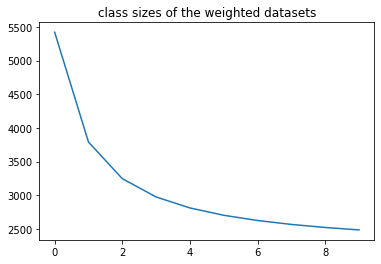

In [16]:
dataset= trainset
dataloader = trainloader
class_ordering = np.arange(10)
class_distribution_counts = get_class_distribution_counts_from_dataset(dataset)
class_to_dataset = get_class_to_dataset(dataset)

plt.plot(np.arange(len(class_distribution_counts)), class_distribution_counts )
plt.title("class sizes of the weighted datasets")
plt.show()

In [17]:
%time

number_of_datasets =num_teachers = 30
weighted_indices = get_weighted_indices(dataset, class_ordering, class_distribution_counts, class_to_dataset)

#unweighted_dataloaders_IID = get_IID_data_loaders(dataloader, num_teachers)
unweighted_datasets_IID = get_IID_datasets(dataset, num_teachers)

weighted_datasets_IID =get_weighted_datasets_IID(dataset,  number_of_datasets, weighted_indices)
weighted_datasets_non_IID = get_weighted_datasets_non_IID(dataset,  number_of_datasets, weighted_indices)

unweighted_dataloaders_IID = [load(ds) for ds in unweighted_datasets_IID]
weighted_dataloaders_IID = [load(ds) for ds in weighted_datasets_IID]
weighted_dataloaders_non_IID = [load(ds) for ds in weighted_datasets_non_IID]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
2000


In [18]:
#len(weighted_datasets_non_IID[0].indices)

## model params


In [19]:
### defaults behaviors:

MAX_GRAD_NORM = 0.3
batch_size = BATCH_SIZE = 32
SAMPLE_RATE = BATCH_SIZE / len(trainset)

VIRTUAL_BATCH_SIZE = 64
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

max_lr = 1e-3 #0.01
weight_decay =1e-4

DELTA = 1. * 1e-5
EPSILON = 2.

optimizer_type = torch.optim.Adam
criterion = nn.CrossEntropyLoss()
EPOCHS = 20



## PATE


In [20]:
ASSETS_BASE_PATH = os.path.join(ASSETS_PATH, "round_7")

In [21]:
%time

number_of_datasets =num_teachers = 75
weighted_indices = get_weighted_indices(dataset, class_ordering, class_distribution_counts, class_to_dataset)

unweighted_datasets_IID = get_IID_datasets(dataset, num_teachers)

weighted_datasets_IID =get_weighted_datasets_IID(dataset,  number_of_datasets, weighted_indices)
weighted_datasets_non_IID = get_weighted_datasets_non_IID(dataset,  number_of_datasets, weighted_indices)

unweighted_dataloaders_IID = [load(ds) for ds in unweighted_datasets_IID]
weighted_dataloaders_IID = [load(ds) for ds in weighted_datasets_IID]
weighted_dataloaders_non_IID = [load(ds) for ds in weighted_datasets_non_IID]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
800


In [22]:
teacher_loaders_dict= {"unweighted_dataloaders_IID":unweighted_dataloaders_IID,
                    "weighted_dataloaders_IID": weighted_dataloaders_IID,
                    "weighted_dataloaders_non_IID":weighted_dataloaders_non_IID
                    }

In [23]:
EPOCHS = 25
batch_size = 50 
prefix  = ""# "test_1"

for teacher_loader_name, teacher_loaders in teacher_loaders_dict.items():
    #teacher_loaders = get_data_loaders(trainset, num_teachers)

    experiments_base_save = os.path.join(f"{ASSETS_BASE_PATH}", prefix)

    meta_yaml = os.path.join(experiments_base_save, "meta.yaml") 

    meta = open_yaml(meta_yaml)
    if not meta:
      meta = {}
    print(teacher_loader_name)
    num_classes = len(trainset.class_to_idx)
    for ind, teacher_loader in enumerate(teacher_loaders): 
        print(teacher_loader)

        print(len(teacher_loader))
        
        teacher_loader = DeviceDataLoader(teacher_loader, device)
        start = datetime.datetime.now()
        model_name = f"model_{ind}_of_{num_teachers}_{teacher_loader_name}"
        print(model_name)
        model = to_device(Model(), device)
        
        run_base_path = os.path.join(f"{experiments_base_save}", model_name)
        # make the directory to which we will save stuff
        os.makedirs(os.path.dirname(run_base_path), exist_ok =True) 
        tensorboard_path = run_base_path 
        save_path = run_base_path + ".pth"
        print(f"tensorboard path is {tensorboard_path}")
        print(f"save_path is {save_path}")
        
        # 
        d = do_it_all(model = model, model_name = model_name,
                                        save_path = save_path, tensorboard_path= tensorboard_path, 
                                        trainloader_ = teacher_loader, val_loader_ = testloader,
                                        num_classes = num_classes, device = device, epochs = EPOCHS)
        print(ind)
        print(d)
        meta[model_name] =d 
        print(f"Model training took {datetime.datetime.now() - start}")

    write_yaml(meta_yaml, meta)
write_yaml(meta_yaml, meta)

unweighted_dataloaders_IID
25
model_0_of_75_unweighted_dataloaders_IID
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/model_0_of_75_unweighted_dataloaders_IID
save_path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/model_0_of_75_unweighted_dataloaders_IID.pth
path /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/model_0_of_75_unweighted_dataloaders_IID.pth already saved to. SKIPPING.
0
{'save_path': '/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/model_0_of_75_unweighted_dataloaders_IID.pth', 'history': None, 'model_name': 'model_0_of_75_unweighted_dataloaders_IID'}
Model training took 0:00:08.351961
25
model_1_of_75_unweighted_dataloaders_IID
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/model_1_of_75_unweighted_dataloaders_IID
save_path is /content/drive/MyDrive/academics/columbia/neu

In [24]:
meta.keys()

dict_keys(['model_0_of_75_unweighted_dataloaders_IID', 'model_0_of_75_weighted_dataloaders_IID', 'model_0_of_75_weighted_dataloaders_non_IID', 'model_10_of_75_unweighted_dataloaders_IID', 'model_10_of_75_weighted_dataloaders_IID', 'model_10_of_75_weighted_dataloaders_non_IID', 'model_11_of_75_unweighted_dataloaders_IID', 'model_11_of_75_weighted_dataloaders_IID', 'model_11_of_75_weighted_dataloaders_non_IID', 'model_12_of_75_unweighted_dataloaders_IID', 'model_12_of_75_weighted_dataloaders_IID', 'model_12_of_75_weighted_dataloaders_non_IID', 'model_13_of_75_unweighted_dataloaders_IID', 'model_13_of_75_weighted_dataloaders_IID', 'model_13_of_75_weighted_dataloaders_non_IID', 'model_14_of_75_unweighted_dataloaders_IID', 'model_14_of_75_weighted_dataloaders_IID', 'model_14_of_75_weighted_dataloaders_non_IID', 'model_15_of_75_unweighted_dataloaders_IID', 'model_15_of_75_weighted_dataloaders_IID', 'model_15_of_75_weighted_dataloaders_non_IID', 'model_16_of_75_unweighted_dataloaders_IID', 'm

In [25]:
def prediction_by_img(model, img, verbose= False):
  """
  returns confidence, prediction
  """
  img = img.cuda()
  img.unsqueeze_(0)
  with torch.no_grad():
    yb = model(img)
  softmax = torch.nn.functional.softmax(yb[0], dim=0)
  conf, pred = torch.max(softmax, dim=0)
  #_, pred = torch.max(yb, dim=1)
  if verbose:
    plt.imshow(img.permute(1, 2, 0))
    print(f"prediction: {trainset.classes[pred]}, confidence {conf * 100}%")
  return conf, pred

def prediction_by_imgs(model, img, verbose= False):
  """
  returns confidence, prediction
  """
  img = img.cuda()
  img.unsqueeze_(0)
  with torch.no_grad():
    yb = model(img)
  softmax = torch.nn.functional.softmax(yb, dim=1)
  conf, pred = torch.max(softmax, dim=1)
  #_, pred = torch.max(yb, dim=1)
  return conf, pred


def save_np_to_filename(filename, arr, overwrite = False):
  if os.path.exists(filename) and not overwrite:
    print("file already exists, ignoring")
    return
  np.save(filename, arr)

def load_np_from_filename(filename):
  if not os.path.exists(filename):
    print("file does not exist")
    return None
  return np.load(filename)


In [26]:
list(meta.keys())[-1]


'student_eps2.0_weighted_dataloaders_non_IID_zscore'

In [27]:
# manual inspection of where a model disagrees
if True:
  model = load_model( meta["model_74_of_75_weighted_dataloaders_non_IID"]['save_path'], Model())
  c = 0
  for ind, (data,target) in enumerate(trainset):
      conf, pred = prediction_by_img(model, data)
      if pred != target:
        c+=1
        print(f"{c}: @ {ind} : prediction {pred}, target {target}")
      if ind ==1000:
        print(f"{c}/1000 disagree with targets")
        break


1: @ 0 : prediction 3, target 5
2: @ 5 : prediction 9, target 2
3: @ 11 : prediction 2, target 5
4: @ 19 : prediction 7, target 9
5: @ 22 : prediction 4, target 9
6: @ 28 : prediction 7, target 2
7: @ 29 : prediction 1, target 7
8: @ 33 : prediction 7, target 9
9: @ 42 : prediction 1, target 7
10: @ 48 : prediction 3, target 9
11: @ 53 : prediction 1, target 4
12: @ 68 : prediction 2, target 0
13: @ 80 : prediction 0, target 9
14: @ 109 : prediction 6, target 2
15: @ 111 : prediction 8, target 3
16: @ 120 : prediction 7, target 2
17: @ 132 : prediction 1, target 5
18: @ 138 : prediction 3, target 5
19: @ 148 : prediction 4, target 7
20: @ 150 : prediction 1, target 4
21: @ 158 : prediction 4, target 7
22: @ 160 : prediction 3, target 8
23: @ 168 : prediction 8, target 7
24: @ 173 : prediction 1, target 5
25: @ 178 : prediction 0, target 2
26: @ 180 : prediction 1, target 2
27: @ 181 : prediction 7, target 3
28: @ 182 : prediction 3, target 5
29: @ 189 : prediction 6, target 2
30: @ 199

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

#trainset = datasets.MNIST(
#    "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)
testset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)

batch_size = 64
load = lambda dataset : torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = load(testset)
testloader = DeviceDataLoader(testloader, device)


#compute validation weights


In [29]:
federated_evaluations = False
if federated_evaluations:
    teacher_loaders = get_data_loaders(trainset, num_teachers)
    experiments_base_save = os.path.join(f"{ASSETS_BASE_PATH}", prefix)
    teacher_evals_yaml = os.path.join(experiments_base_save, "teacher_evals.yaml") 
    teacher_evals = open_yaml(teacher_evals_yaml)
    if not teacher_evals:
      teacher_evals = {}   # maps model_ind to its validation score

    for model_ind, model in enumerate(models):
        teacher_evals[model_ind] = 0
        for ind, teacher_loader in enumerate(teacher_loaders): 
            # load model
            # calculate the average evaluation on each of the other datasets
            # ideally this would be calculated by averaging the validation error on every one else's data
            if ind == model_ind:
              continue
            teacher_evals[model_ind]+= evaluate(model, teacher_loader, criterion)
        teacher_evals[model_ind] = teacher_evals[model_ind]/ len(models) # take the average of the evaluation # Note: may need to make this a weighted average.

    write_yaml(meta_yaml, meta)

In [30]:
if False:
  validations = {}

  for model_ind, (name, meta_entry) in enumerate(meta.items()):
      model = load_model(meta_entry['save_path'], Model())
      print(model)
      break


# Compute histogram of voting


## ways to compute weightings for votes

In [31]:
# ways to weight the validation accuracies:

def softmax(arr):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(arr - np.max(arr))
    return e_x / e_x.sum(axis=0) # only difference


def get_z_scores(arr):
  """ computes z-score array"""
  arr_mean, arr_std = (arr).mean(), (arr).std()
  return (arr - arr_mean)/ arr_std 


def get_rank_by_ind(ind, arr):
    """ computes the ranking of the value at index ind, if ranked by size"""
    # computes number of points smaller than it
    return sum(accuracy_zscores[ind] >= accuracy_zscores)


def get_rankings(arr):
    """ computes the ranking of the value for entire array, if ranked by size"""
    # computes number of points smaller than it
    #return sum(accuracy_zscores[ind] >= accuracy_zscores)
    return np.array(list(
                          map(
                              lambda val: sum(val >= accuracies), 
                              accuracies
                              )
                          )
                      )
    
def get_percentile(val, arr, min_val= 0, max_val = 1.):
    hist,bins =np.histogram(arr, bins =np.linspace(min_val, max_val, num = 101)) 
    bin_ind = np.argmin(val > bins) # get the bin that contains val 
    return sum(hist[:bin_ind]) -1 

def get_percentiles(arr, min_val= 0, max_val = 1.):
    return np.array(
        list(map( lambda i : get_percentile(i, accuracies, min_val = min_val, max_val = max_val), accuracies ))
    )

def get_weights_by_percentile(arr, min_weight, max_weight, min_val=0, max_val= 1.):
    """ given a np array of values (from min_val to max_val) 

    return an array that weights the values between min_weight and max weight, 
        according to the percentile the value belongs to (repeat values allowed)
    """
    percentiles = get_percentiles(arr,min_val = min_val, max_val= max_val)
    scaling = (1/(100.)) # scale the values to between 0 and 1

    range_ = (max_weight - min_weight)
    weights = (percentiles *scaling * range_ ) + min_weight
    return weights

def get_weights_by_rank(arr, min_weight, max_weight):
    """ given a np array of values (from min_val to max_val) 

    return an array that weights the values between min_weight and max weight, 
        according to the ranking of the value (i.e. if you create an ordered list, what index the value comes in)
    """
    scaling = (1./(len(arr))) # scale the values to between 0 and 1

    ranks = get_rankings(arr)
    
    range_ = (max_weight - min_weight)
    weights = (ranks * scaling * range_ ) + min_weight
    return weights

def get_weights_by_value(arr, min_weight, max_weight, min_val=0., max_val= 1.):
    """ given a np array of values (from min_val to max_val) 

    return an array that weights the values between min_weight and max weight, 
        according to value itself
    
    """
    scaling = (1/(max_val - min_val)) # scale the values to between 0 and 1
    range_ = (max_weight - min_weight)
    weights = (arr * scaling * range_ ) + min_weight
    return weights

def get_weights_by_zscores(arr, min_weight = 0.1 , max_weight = 2.):
    """ note the contribution of a single model is unbounded, so actually makes PATE privacy much harder
    I do not recommend this method
    """
    z_scores = get_z_scores(arr)
    range_ = max(z_scores) - min(z_scores)
    z_score_weights = (((z_scores - min(z_scores)) *  # make weights positive
                        (1./range_) * (max_weight- min_weight) ) # scale weights between the range
                          + min_weight ) # add min_weight
    return z_score_weights



In [32]:
%%time
# compute the vote_hist
# to do : don't compute vote_hist directly, instead compute "teacher_preds", and create a function that converts teacher_preds to vote_hist.
def compute_teacher_preds(meta_data, dataset, dataloader,   teacher_preds_filepath , overwrite = False, verbose = True):
    # load from filepath
    teacher_preds_loaded = load_np_from_filename(teacher_preds_filepath)
    if not overwrite and (teacher_preds_loaded is not None):
        print("Loading from memory")
        return teacher_preds_loaded      

    num_teachers = len(meta_data)
    teacher_preds = np.zeros(( len(dataset), num_teachers ) ) 
      
    for model_ind, (name, meta) in enumerate(meta_data.items()):
        if verbose:
            print(f"model {name}.")
        start = datetime.datetime.now()        
        model = load_model(meta['save_path'], Model())
        
        ind = 0
        for batch_idx, (data, targets) in enumerate(dataloader):
            confs, preds = prediction_by_imgs(model, data)
            
            for conf, pred, target in zip(confs, preds, targets):
                # store what the model predicted 
                teacher_preds[ind][model_ind] = pred
                ind +=1

    save_np_to_filename(teacher_preds_filepath, teacher_preds, overwrite = overwrite)
    
    return teacher_preds


def compute_vote_hist_from_teacher_preds(teacher_preds, num_classes, dataset):
  """
  teacher_preds = np.zeros(( len(dataset), num_teachers ) ) 

  """
  vote_hist = np.zeros((len(dataset), num_classes))
  for ind, teacher_preds_row in enumerate(teacher_preds):
      hist, _ = np.histogram(teacher_preds_row, bins = num_classes, range = (0, num_classes))
      vote_hist[ind] = hist 
  return vote_hist

def get_accuracy(predictions, dataset):
  return 1.* sum(predictions == dataset.targets) / len(dataset.targets)

def compute_accuracies_from_teacher_preds(teacher_preds, dataset):
  """
  teacher_preds = np.zeros(( len(dataset), num_teachers ) ) 
  """
  #compare teacher predictions for the model, to dataset.targets
  N, num_teachers = teacher_preds.shape
  accuracies = np.zeros(num_teachers)
  targets = dataset.targets.numpy()
  for ind in range(num_teachers):
      accuracies[ind] = 1.* sum(teacher_preds.T[ind] == targets) / (1.*N)
  return accuracies

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [33]:
def compute_weighted_vote_hist_from_teacher_preds(weight_function, teacher_preds, 
                                                  num_classes, dataset, 
                                                  min_weight = 0.5, max_weight = 2.5):
  """
  given some teacher weighting, compute new vote counts
    weight by percentile
  """
  print("compute_percentile_weighted_vote_hist_from_teacher_preds")
  weights = weight_function(accuracies,min_weight = min_weight, max_weight =max_weight)
  vote_hist = np.zeros((len(dataset), num_classes))
  for ind, teacher_preds_row in enumerate(teacher_preds):
      hist, _ = np.histogram(teacher_preds_row, bins = num_classes, range = (0, num_classes), weights = weights)
      vote_hist[ind] = hist 
  return vote_hist



compute_z_score_weighted_vote_hist_from_teacher_preds =toolz.curry(compute_weighted_vote_hist_from_teacher_preds, get_weights_by_zscores)
compute_accuracy_weighted_vote_hist_from_teacher_preds  =toolz.curry(compute_weighted_vote_hist_from_teacher_preds, get_weights_by_value)
compute_percentile_weighted_vote_hist_from_teacher_preds =toolz.curry(compute_weighted_vote_hist_from_teacher_preds, get_weights_by_percentile)
compute_ranking_weighted_vote_hist_from_teacher_preds =toolz.curry(compute_weighted_vote_hist_from_teacher_preds, get_weights_by_rank)

### Thoughts about different kinds of weights:
1. can weight by accuracy PER-class (this would help if one model does really well on 1 class
2. interactive weighting (during the evaluation period, when you are creating labels for the the student dataset) - weigh the votes according to how similar they are to one another
  1. actually, consider looking at model-similarity all together. Can we easily compute how similar 1 model is to the others, and then take that into account when weighing by validation accuracy as well (as in, some metric of what kinds of data points 1 model gets correct that others do not; perhaps just by looking at the distance between the pts models get correct). If you have points : a1 a2 a3 b1 b2 b3. And you have models 1-99 get A's right, but B's wrong. And model 100 get B's right but A's wrong, you should weight model 100 more. This could be done by some kind of density measure on the types of points that models get correct (as in, each time you correctly label a point, you increase that points' prototypicalness, and then at the end you weigh the model by its ability to label non-prototypical points.)


### thoughts about differents places for DP:
1. can add privacy amplification by subsampling to the voting mechanism actually, to increase privacy gains.


## thoughts copied:
[x] split the dataset into uneven chunks
[x] train the models, save them, and store where you are saving them (persist the data somewhere like to a yaml, or you will lose it)
[x] have each model vote on each data point in the test-dataset, store that to a yaml
 

### Potential idea about weighting:

In [34]:
def get_teacher_label(model_name, suffix_start_index =4):
  """ given model name "model_0_of_75_unweighted_dataloaders_IID"
  return string, of the form "unweighted_dataloaders_IID"
  # suffix_start_index is the index of "_" to start at
  """
  return "_".join(model_name.split("_")[suffix_start_index:])


In [35]:

# maps dict_keys(['unweighted_dataloaders_IID', 'weighted_dataloaders_IID', 'weighted_dataloaders_non_IID'])
#     to a list of models for those teachers 
teacher_group_infos = {} 
for model_name, meta_info in meta.items():
    teacher_label =get_teacher_label(model_name)
    if "weighted" not in teacher_label:
        continue
    if teacher_label not in teacher_group_infos:
      teacher_group_infos[teacher_label] = {}
    teacher_group_infos[teacher_label][model_name] =meta_info


In [36]:
teacher_group_infos.keys()

dict_keys(['unweighted_dataloaders_IID', 'weighted_dataloaders_IID', 'weighted_dataloaders_non_IID'])

In [37]:
%%time
dataset = testset
dataloader = testloader
teacher_predictions = {}
for teacher_group_name, teacher_infos in teacher_group_infos.items():
    print(teacher_group_name)
    print(len(teacher_infos))
    pref = "" #trial_1
    teacher_preds_path = os.path.join(ASSETS_BASE_PATH, pref, f"teacher_preds_models_{teacher_group_name}_{len(teacher_infos)}.npy")
    os.makedirs(os.path.dirname(teacher_preds_path), exist_ok = True)
    print(os.path.exists(teacher_preds_path))
    print(teacher_preds_path)
    teacher_predictions[teacher_group_name] = compute_teacher_preds(teacher_infos, 
                                                                    dataset= dataset, 
                                                                    dataloader = dataloader,
                                                                    teacher_preds_filepath = teacher_preds_path,
                                                                    overwrite = False,
                                                                    verbose = True)

unweighted_dataloaders_IID
75
True
/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/teacher_preds_models_unweighted_dataloaders_IID_75.npy
Loading from memory
weighted_dataloaders_IID
75
True
/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/teacher_preds_models_weighted_dataloaders_IID_75.npy
Loading from memory
weighted_dataloaders_non_IID
75
True
/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/teacher_preds_models_weighted_dataloaders_non_IID_75.npy
Loading from memory
CPU times: user 39.8 ms, sys: 14.3 ms, total: 54.1 ms
Wall time: 4.85 s


In [38]:
def compute_vote_hist_dict(teacher_preds, num_classes, dataset, min_weight = .5 , max_weight =3):
  vote_hist = compute_vote_hist_from_teacher_preds(teacher_preds, num_classes, dataset)

  percentile_vote_hist = compute_percentile_weighted_vote_hist_from_teacher_preds(teacher_preds, 
                                                                                  num_classes, dataset, 
                                                                                  min_weight = min_weight, max_weight= max_weight)
  ranking_vote_hist = compute_ranking_weighted_vote_hist_from_teacher_preds(teacher_preds, num_classes, 
                                                                            dataset, min_weight = min_weight, max_weight= max_weight)
  accuracy_vote_hist = compute_accuracy_weighted_vote_hist_from_teacher_preds(teacher_preds, num_classes,
                                                                              dataset, min_weight = min_weight, max_weight= max_weight)
  z_score_vote_hist = compute_z_score_weighted_vote_hist_from_teacher_preds(teacher_preds, num_classes, 
                                                                            dataset, min_weight = min_weight, max_weight= max_weight)

  vote_histogram_dict = {
      "ordinary" : vote_hist,
      "percentile" :  percentile_vote_hist,
      "ranking": ranking_vote_hist,
      "accuracy": accuracy_vote_hist,
      "zscore" : z_score_vote_hist
  }
  return vote_histogram_dict

def compare(ind,vote_hist_, dataset = testset):
  print(f"Prediction: \tP: {np.argmax(vote_hist_[ind])}   \t\t{vote_hist[ind]}")
  print(f"real        \t R: {dataset.targets[ind]}  ")
  

unweighted_dataloaders_IID
64.62 88.73


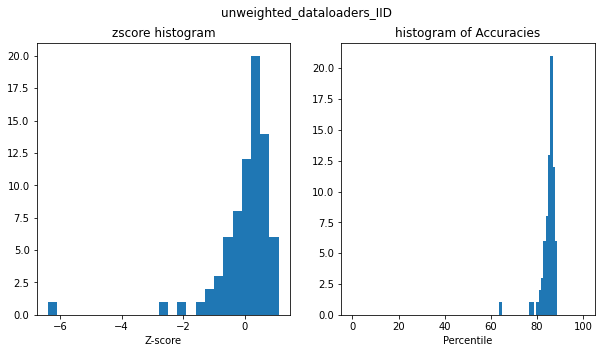

weighted_dataloaders_IID
81.92 86.50999999999999


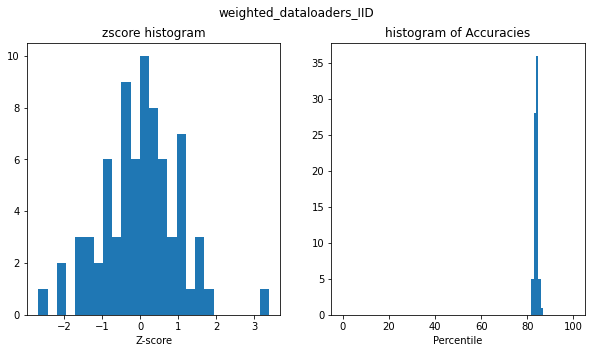

weighted_dataloaders_non_IID
75.51 84.93


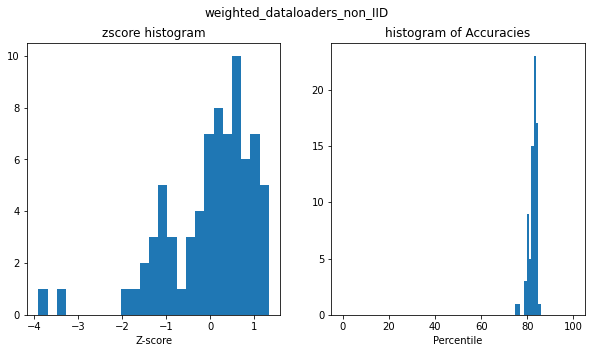

In [39]:
from matplotlib import pyplot as plt 
import numpy as np  

teacher_predictions # is a dictionary
teacher_accuracies = {}
for teacher_predictions_name, predictions in teacher_predictions.items(): 
    print(f"{teacher_predictions_name}")
    accuracies = compute_accuracies_from_teacher_preds(predictions, dataset)
    teacher_accuracies[teacher_predictions_name]= accuracies

    #get_percentile(np.max(accuracies), accuracies)


    hist,bins =np.histogram(accuracies * 100. ,bins =np.linspace(0,100, num = 101)) 

    accuracy_mean, accuracy_std = (accuracies*100).mean(), (accuracies*100).std()

    accuracy_zscores = ((accuracies*100) - accuracy_mean)/ accuracy_std
    accuracy_zscores

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"{teacher_predictions_name}")

    ax1.hist(accuracy_zscores, bins = 25)
    ax1.set_title(f"zscore histogram")
    ax1.set_xlabel("Z-score")

    
    min_accuracies, max_accuracies = min(accuracies) *100, max(accuracies)*100
    ax2.hist(accuracies * 100. ,bins =np.linspace(0,100, num = 100))
    print(min_accuracies, max_accuracies)
    #ax2.hist(accuracies * 100. ,bins =np.linspace(min_accuracies, max_accuracies, num = 101))#, range =(min_accuracies, max_accuracies))
    
    ax2.set_title(f"histogram of Accuracies") 
    ax2.set_xlabel("Percentile")
    plt.show()

# ways to weight the validation accuracies:


In [40]:
for teacher_group, accuracies in teacher_accuracies.items():
    print(teacher_group)
    print(sum(accuracies)/len(accuracies))

unweighted_dataloaders_IID
0.8517720000000002
weighted_dataloaders_IID
0.8394453333333334
weighted_dataloaders_non_IID
0.8253493333333333


unweighted_dataloaders_IID


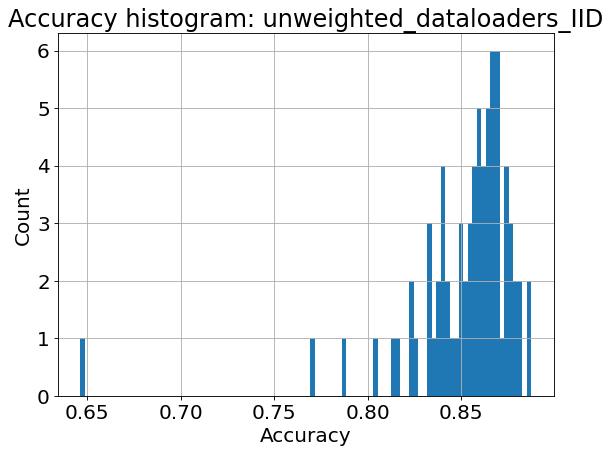

weighted_dataloaders_IID


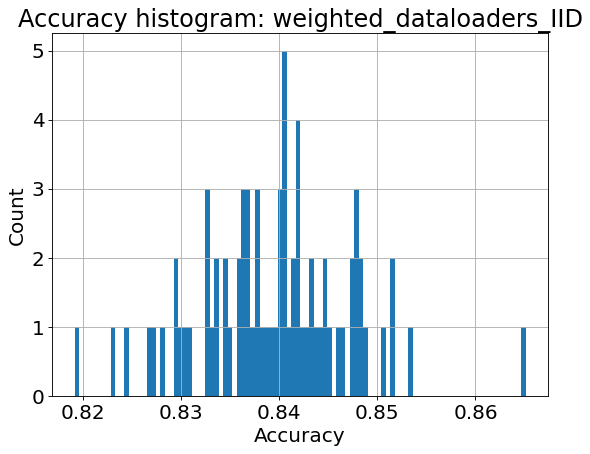

weighted_dataloaders_non_IID


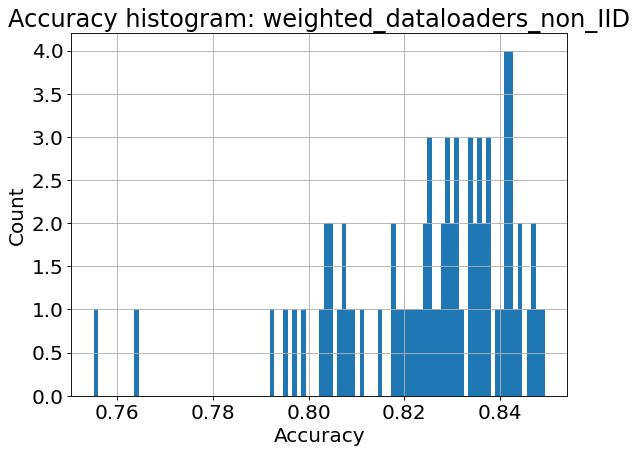

In [63]:
#x = np.arange(1,11) 
#y = 2 * x + 5 
def plot_accuracies(accuracies, title ):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"{title}")
    """
    ax1.set_title("Accuracy") 
    ax1.set_xlabel("model number") 
    ax1.set_ylabel("Accuracy percent") 
    ax1.plot(accuracies) 
    """
    sorted_accuracies = sorted(accuracies)
    ax1.set_title("Sorted Accuracies") 
    ax1.plot(sorted_accuracies) 
    ax1.set_ylabel("accuracy")
    
    ax2.set_title("Accuracy histogram") 
    ax2.hist(accuracies, bins = 100) 
    ax2.set_xlabel("Accuracy")
    ax2.set_ylabel("Count")

    ax3.set_title("box and whiskers")
    ax3.boxplot(sorted_accuracies)
    ax3.set_ylabel("Accuracy")
    plt.show()
verbose = False
plt.rcParams.update({'font.size': 18}) # must set in top
for teacher_group_name, accuracies in teacher_accuracies.items():
    print(f"{teacher_group_name}")
    #plot_accuracies(accuracies, title = teacher_group_name)
    from matplotlib.pyplot import figure
    
    figure(figsize=(8, 6), dpi=80)
    plt.title(f"Accuracy histogram: {teacher_group_name}") 
    plt.hist(accuracies, bins = 100) 
    plt.xlabel("Accuracy")
    plt.ylabel("Count")
    plt.grid()
    plt.show()
    sorted_accuracies = sorted(accuracies)
    percentage = len(sorted_accuracies)/100.
    if verbose:
      print(f"0th percentile : \t {sorted_accuracies[0]}")
      print(f"25th percentile :\t {sorted_accuracies[int(25 * percentage)]}")
      print(f"Median :\t\t {sorted_accuracies[int(50 * percentage)]}")
      print(f"75th percentile :\t {sorted_accuracies[int(75 * percentage)]}")
      print(f"100th percentile :\t {sorted_accuracies[-1]}")

In [42]:
def laplaceMechanism(x, epsilon, sensitivity = 1.0):
    # sensitivity = 1
    return x + np.random.laplace(0, scale = sensitivity/epsilon, size = x.shape)
    
def laplacify_votes(vote_hist, eps = 3. ):
  # https://becominghuman.ai/differential-privacy-noise-adding-mechanisms-ede242dcbb2e
  return laplaceMechanism(vote_hist, epsilon = eps)

def get_labels(vote_hist):
  return np.array([int(np.argmax(vote)) for vote in vote_hist])


def get_noisy_labels(vote_hist, epsilon = 3.):
  """ Give a histogram of votes, and noise to it, and get the maximum voted for label"""
  return np.array(get_labels(laplacify_votes(vote_hist, eps = epsilon)))

def get_student_dataset_and_dataloader( vote_hist, epsilon=3.0):
    student_dataset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)

    vote_hist_ = vote_hist.copy()
    # put this back later
    student_dataset.targets = get_noisy_labels(vote_hist_)
    student_dataloader = load(student_dataset)
    # send this to the device
    student_dataloader = DeviceDataLoader(student_dataloader, device)
    return student_dataset, student_dataloader


# how often does the new targets differ from the old targets:
def get_alignment_with_original_dataset(student_dataset, dataset, verbose = True):
    diffs = 0
    for i in range(len(student_dataset.targets)):
      if student_dataset.targets[i] != dataset.targets[i]: #testset.targets[i]:
        diffs+=1
    if verbose:
        print(f"{diffs} /{len(dataset)}. alignment : {100* (1-(diffs/len(dataset)))}%")
    return diffs



def get_vote_type_datasets(vh_dict, epsilon):

    # map vote_hist_name to tuple( student_dataset, student_dataloader)
    vote_type_datasets = {vote_hist_name : 
                                          get_student_dataset_and_dataloader(vote_hist, epsilon = epsilon) 
                                          for vote_hist_name, vote_hist 
                                                                        in vh_dict.items()}
    return vote_type_datasets


In [43]:
dataset = testset
teacher_group_vote_hist_dictionary = {}
teacher_group_vote_type_datasets = {}

for teacher_group_name, predictions in teacher_predictions.items():
    print(f"{teacher_group_name} !")
    vh_dict = compute_vote_hist_dict(predictions, 
                                    num_classes, dataset, 
                                    min_weight = .1, max_weight =3) # observation if the max contribution differs by even 100 vs .1, it does not change the accuracy once

    teacher_group_vote_hist_dictionary[teacher_group_name] = vh_dict

    for name, vh in vh_dict.items():
      labels = get_labels(vh)
      print(f"{name} : \tAccuracy : {100 * sum(np.array(labels) == dataset.targets.numpy())/ len(dataset)}")

    epsilon = 3.

    vote_type_datasets = get_vote_type_datasets(vh_dict, epsilon)
    teacher_group_vote_type_datasets[teacher_group_name] = vote_type_datasets

unweighted_dataloaders_IID !
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
ordinary : 	Accuracy : 91.56
percentile : 	Accuracy : 91.67
ranking : 	Accuracy : 91.66
accuracy : 	Accuracy : 91.62
zscore : 	Accuracy : 91.62
weighted_dataloaders_IID !
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
ordinary : 	Accuracy : 87.58
percentile : 	Accuracy : 87.51
ranking : 	Accuracy : 87.49
accuracy : 	Accuracy : 87.62
zscore : 	Accuracy : 87.61
weighted_dataloaders_non_IID !
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_preds
compute_percentile_weighted_vote_hist_from_teacher_pred

In [44]:
for teacher_group_name, vote_type_datasets in teacher_group_vote_type_datasets.items():
    print(f"{teacher_group_name}")
    for vote_hist_name, (student_dataset, student_dataloader) in vote_type_datasets.items():
        get_alignment_with_original_dataset(student_dataset, dataset, verbose= True)

    for vote_hist_name, vote_hist in vh_dict.items():
        break

    print("Compare difference between vote_hist, and actual dataset:")
    for i in range(3):
      compare(i, dataset = testset, vote_hist_ = vote_hist)

unweighted_dataloaders_IID
838 /10000. alignment : 91.62%
836 /10000. alignment : 91.64%
835 /10000. alignment : 91.64999999999999%
840 /10000. alignment : 91.60000000000001%
834 /10000. alignment : 91.66%
Compare difference between vote_hist, and actual dataset:
Prediction: 	P: 7   		[ 0.  0.  0.  0.  0.  0.  0. 75.  0.  0.]
real        	 R: 7  
Prediction: 	P: 2   		[ 1.  0. 50.  3.  0.  3. 18.  0.  0.  0.]
real        	 R: 2  
Prediction: 	P: 1   		[ 0. 75.  0.  0.  0.  0.  0.  0.  0.  0.]
real        	 R: 1  
weighted_dataloaders_IID
1240 /10000. alignment : 87.6%
1249 /10000. alignment : 87.51%
1249 /10000. alignment : 87.51%
1239 /10000. alignment : 87.61%
1238 /10000. alignment : 87.62%
Compare difference between vote_hist, and actual dataset:
Prediction: 	P: 7   		[ 0.  0.  0.  0.  0.  0.  0. 75.  0.  0.]
real        	 R: 7  
Prediction: 	P: 2   		[ 1.  0. 50.  3.  0.  3. 18.  0.  0.  0.]
real        	 R: 2  
Prediction: 	P: 1   		[ 0. 75.  0.  0.  0.  0.  0.  0.  0.  0.]
real 

In [45]:
teacher_group_vote_hist_dictionary.keys()
#dict_keys(['unweighted_dataloaders_IID', 'weighted_dataloaders_IID', 'weighted_dataloaders_non_IID'])
teacher_group_vote_hist_dictionary["unweighted_dataloaders_IID"].keys()

dict_keys(['ordinary', 'percentile', 'ranking', 'accuracy', 'zscore'])

In [46]:
vote_hist = teacher_group_vote_hist_dictionary["unweighted_dataloaders_IID"]["accuracy"]
test_laplacify_votes = True
if test_laplacify_votes:
  m = 2
  count = 0
  eps = 0.1
  print(f"max_difference: {sum(sum(abs(vote_hist - laplacify_votes(vote_hist, eps =eps))))}")

  for i, noisy_i in zip(vote_hist, laplacify_votes(vote_hist, eps =eps)):
    print(f"diff between vote and laplacified votes:  {i.astype(int) - noisy_i.astype(int)}")
    print(f"diff between vote and laplacified votes:  {sum(i.astype(int) - noisy_i.astype(int))}")
    print(np.argmax(i))
    #print(noisy_i.astype(int))
    print(np.argmax( noisy_i))
    print("---")
    count+=1
    if count>m:
      break


max_difference: 998517.6859248974
diff between vote and laplacified votes:  [ -2  -9   1 -14   0  22 -11  10  -6 -17]
diff between vote and laplacified votes:  -26
7
7
---
diff between vote and laplacified votes:  [  0  -8   4 -18   5   3  17  16 -14  11]
diff between vote and laplacified votes:  16
2
2
---
diff between vote and laplacified votes:  [ 11  -6  25 -22   0  -7  -3   7   3  22]
diff between vote and laplacified votes:  30
1
1
---



## Train Student

In [47]:
EPOCHS = 25
epsilon = 2.0

for teacher_group_name, vote_type_datasets in teacher_group_vote_type_datasets.items():
    print("teacher_group_name ", teacher_group_name)
    model = to_device(Model(), device)
    #vote_type_datasets = get_vote_type_datasets(vh_dict, epsilon)
    for vote_hist_name, (student_dataset, student_dataloader) in vote_type_datasets.items():
        vote_hist_name_label = f"{teacher_group_name}_{vote_hist_name}"
        
        vote_hist_name_label= vote_hist_name_label.replace("zscore", "z_score")

        print(f"trying {vote_hist_name_label} voting histogram")
        base_save = os.path.join(f"{ASSETS_BASE_PATH}",f"num_teachers_{num_teachers}__student_{epsilon}__vote_hist_type_{vote_hist_name_label}")
        # make the directory to which we will save stuff
        os.makedirs(os.path.dirname(base_save), exist_ok =True) 
        tensorboard_path = base_save 
        save_path = base_save + ".pth"
        print(f"tensorboard path is {tensorboard_path}")
        print(f"save_path is {save_path}")
        model_name = f"student"
        # 

        meta = open_yaml(meta_yaml)
        if not meta:
          print(f"no data in {meta_yaml}")
          meta = {}
          
        student_info = do_it_all(model = model, model_name = model_name,
                                        save_path = save_path, tensorboard_path= tensorboard_path, 
                                        trainloader_ = student_dataloader, val_loader_ = testloader,
                                        num_classes = num_classes, device = device, epochs = EPOCHS, overwrite=False)
        vote_hist_name_label = vote_hist_name_label.replace("z_score", "zscore")
        print(vote_hist_name_label)
        meta[f"student_eps{epsilon}_{vote_hist_name_label}"] = student_info
        if student_info:
          write_yaml(meta_yaml, meta)

teacher_group_name  unweighted_dataloaders_IID
trying unweighted_dataloaders_IID_ordinary voting histogram
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/num_teachers_75__student_2.0__vote_hist_type_unweighted_dataloaders_IID_ordinary
save_path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/num_teachers_75__student_2.0__vote_hist_type_unweighted_dataloaders_IID_ordinary.pth
path /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/num_teachers_75__student_2.0__vote_hist_type_unweighted_dataloaders_IID_ordinary.pth already saved to. SKIPPING.
unweighted_dataloaders_IID_ordinary
trying unweighted_dataloaders_IID_percentile voting histogram
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_7/num_teachers_75__student_2.0__vote_hist_type_unweighted_dataloaders_IID_percentile
save_path is /content/drive/MyDrive/academics/columbia/neur

In [48]:
student_models = {k:v for k,v in meta.items() if "student" in k}
student_models.keys()
#"student_eps0.5_unweighted_dataloaders_IID_accuracy".split("_")[1]

dict_keys(['student_eps0.5_unweighted_dataloaders_IID_accuracy', 'student_eps0.5_unweighted_dataloaders_IID_ordinary', 'student_eps0.5_unweighted_dataloaders_IID_percentile', 'student_eps0.5_unweighted_dataloaders_IID_ranking', 'student_eps0.5_unweighted_dataloaders_IID_zscore', 'student_eps0.5_weighted_dataloaders_IID_accuracy', 'student_eps0.5_weighted_dataloaders_IID_ordinary', 'student_eps0.5_weighted_dataloaders_IID_percentile', 'student_eps0.5_weighted_dataloaders_IID_ranking', 'student_eps0.5_weighted_dataloaders_IID_zscore', 'student_eps0.5_weighted_dataloaders_non_IID_accuracy', 'student_eps0.5_weighted_dataloaders_non_IID_ordinary', 'student_eps0.5_weighted_dataloaders_non_IID_percentile', 'student_eps0.5_weighted_dataloaders_non_IID_ranking', 'student_eps0.5_weighted_dataloaders_non_IID_zscore', 'student_eps2.0_unweighted_dataloaders_IID_accuracy', 'student_eps2.0_unweighted_dataloaders_IID_ordinary', 'student_eps2.0_unweighted_dataloaders_IID_percentile', 'student_eps2.0_un

In [49]:
ranking_style_accuracies = {}
print(f"epsilon is {epsilon}")
for student_name, student_info in student_models.items():
    eps = student_name.split("_")[1]
    teacher_group = "_".join(student_name.split("_")[2:-1])
    ranking_type = "_".join(student_name.split("_")[-1:])
    
    save_path = student_info.get("save_path")
    model = load_model(save_path, model)
    evaluation = evaluate(model, testloader, criterion) 
    #print(evaluation)

    if teacher_group not in ranking_style_accuracies:
        ranking_style_accuracies[teacher_group] = {}
    if ranking_type not in ranking_style_accuracies[teacher_group]:
        ranking_style_accuracies[teacher_group][ranking_type] = {}

    ranking_style_accuracies[teacher_group][ranking_type] = evaluation.get("val_acc")
    print(f"Epsilon: {eps} : {teacher_group} - {ranking_type} : \t {evaluation.get('val_acc') * 100.}")
      

epsilon is 2.0
Epsilon: eps0.5 : unweighted_dataloaders_IID - accuracy : 	 91.69983863830566
Epsilon: eps0.5 : unweighted_dataloaders_IID - ordinary : 	 91.66998267173767
Epsilon: eps0.5 : unweighted_dataloaders_IID - percentile : 	 91.56050682067871
Epsilon: eps0.5 : unweighted_dataloaders_IID - ranking : 	 91.63017272949219
Epsilon: eps0.5 : unweighted_dataloaders_IID - zscore : 	 91.2619411945343
Epsilon: eps0.5 : weighted_dataloaders_IID - accuracy : 	 87.43033409118652
Epsilon: eps0.5 : weighted_dataloaders_IID - ordinary : 	 87.04219460487366
Epsilon: eps0.5 : weighted_dataloaders_IID - percentile : 	 87.23129034042358
Epsilon: eps0.5 : weighted_dataloaders_IID - ranking : 	 87.15167045593262
Epsilon: eps0.5 : weighted_dataloaders_IID - zscore : 	 87.529855966568
Epsilon: eps0.5 : weighted_dataloaders_non_IID - accuracy : 	 87.43033409118652
Epsilon: eps0.5 : weighted_dataloaders_non_IID - ordinary : 	 86.41520738601685
Epsilon: eps0.5 : weighted_dataloaders_non_IID - percentile 

In [50]:
#ranking_style_accuracies
import pandas as pd

min_accuracy = min(min(ranking_style_accuracies[k].values()) for k in ranking_style_accuracies.keys())  
max_accuracy = max(max(ranking_style_accuracies[k].values()) for k in ranking_style_accuracies.keys())
range_ = (max_accuracy - min_accuracy)
buffer = range_ * 0.5
min_y, max_y = max(0, min_accuracy- buffer),min(1., max_accuracy+ buffer/2.)

plt.rcParams.update({'font.size': 12}) # must set in top

pd.DataFrame(ranking_style_accuracies).T.plot(kind='bar', figsize=(12,8), rot=0)
plt.ylim((min_y, max_y))
plt.title("Student Accuracies")
plt.xlabel("Skew of Dataset")
plt.ylabel("Accuracy")

plt.show()

ImportError: ignored

In [ ]:
for i in ranking_style_accuracies:
  for j in ranking_style_accuracies[i]:
    if ranking_style_accuracies[i][j] <= 1:
      ranking_style_accuracies[i][j] *=100

min_accuracy = min(min(ranking_style_accuracies[k].values()) for k in ranking_style_accuracies.keys())  
max_accuracy = max(max(ranking_style_accuracies[k].values()) for k in ranking_style_accuracies.keys())
range_ = (max_accuracy - min_accuracy)
buffer = range_ * 0.5
min_y, max_y = max(0, min_accuracy- buffer),min(100., max_accuracy+ buffer/2.)
plt.rcParams.update({'font.size': 20}) # must set in top
df = pd.DataFrame(ranking_style_accuracies)
print(df.columns)
df= df.rename(columns= { 
    'unweighted_dataloaders_IID': "IID unweighted"
    , 'weighted_dataloaders_IID': "IID weighted"
    ,'weighted_dataloaders_non_IID': "Non-IID weighted"

})
print(df.columns)
df.T.plot(kind='bar', figsize=(12,10), rot=0)
plt.ylim((min_y, max_y))
plt.title("Student Accuracies")
plt.xlabel("Skew of Dataset")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [ ]:
#%tensorboard --logdir /content/drive/MyDrive/academics/columbia/neural_networks/project/data/

In [ ]:
!pip install syft==0.2.9

In [65]:
!pip list | grep "syft"

syft                          0.2.9
syft-proto                    0.5.3


In [ ]:
import syft

In [ ]:
epsilon

In [ ]:
import syft as sy
from syft.frameworks.torch.dp import pate

In [ ]:
?pate.perform_analysis

In [ ]:
for teacher_group_name, v in teacher_group_vote_hist_dictionary.items():
  print(v.keys())
  break

In [ ]:
%%time 
%%capture 
eps_test = [0.1, 0.5, 2.0, 6.0] # 4., 10., 40.]
eps_d = {}

for teacher_group_name, teacher_preds in teacher_predictions.items():
    print(teacher_group_name)
    for eps in eps_test:
        print(f"eps : {eps}")

        vote_hist= compute_vote_hist_from_teacher_preds(teacher_preds, num_classes=10, dataset=testset)
        data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds.T.astype(int), # note might need to transpose this
                                                          indices= get_noisy_labels(vote_hist, epsilon = eps), # student_dataset.targets, 
                                                          noise_eps=epsilon, 
                                                          delta=1e-5);
        print("Data Independent Epsilon:", data_ind_eps)
        print("Data Dependent Epsilon:", data_dep_eps)
        eps_d[f"{teacher_group_name}_{eps}"] = {"data_dep_eps": data_dep_eps, "data_dep_eps, data_ind_eps": data_ind_eps}

In [ ]:
eps_d

In [ ]:
for k,v in eps_d.items():
  print(f"{k}: {v}")

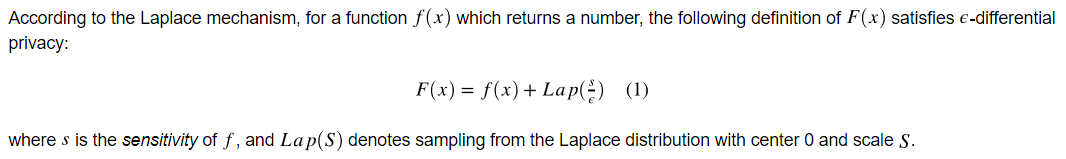